In [2]:
!pip install gpflow
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 11.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from glob import glob

import tensorflow as tf
import gpflow
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [4]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [6]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [7]:
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

AREA_of_EARTH = 510.1 * 1e6 #million km²

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).sum(['latitude', 'longitude'])



In [8]:
from matplotlib import transforms

In [9]:
def add_label(label, ax=None, fig=None, fontsize='medium', va='bottom', x=0., y=1., **kwargs):
    if ax is None:
        ax = plt.gca()
    if fig is None:
        fig = plt.gcf()
    trans = transforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(x, y, label, transform=ax.transAxes + trans,
            fontsize=fontsize, va=va, **kwargs)

In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [11]:
inputs = glob(os.path.join(train_path , "inputs_his*.nc"))
inputs.sort()

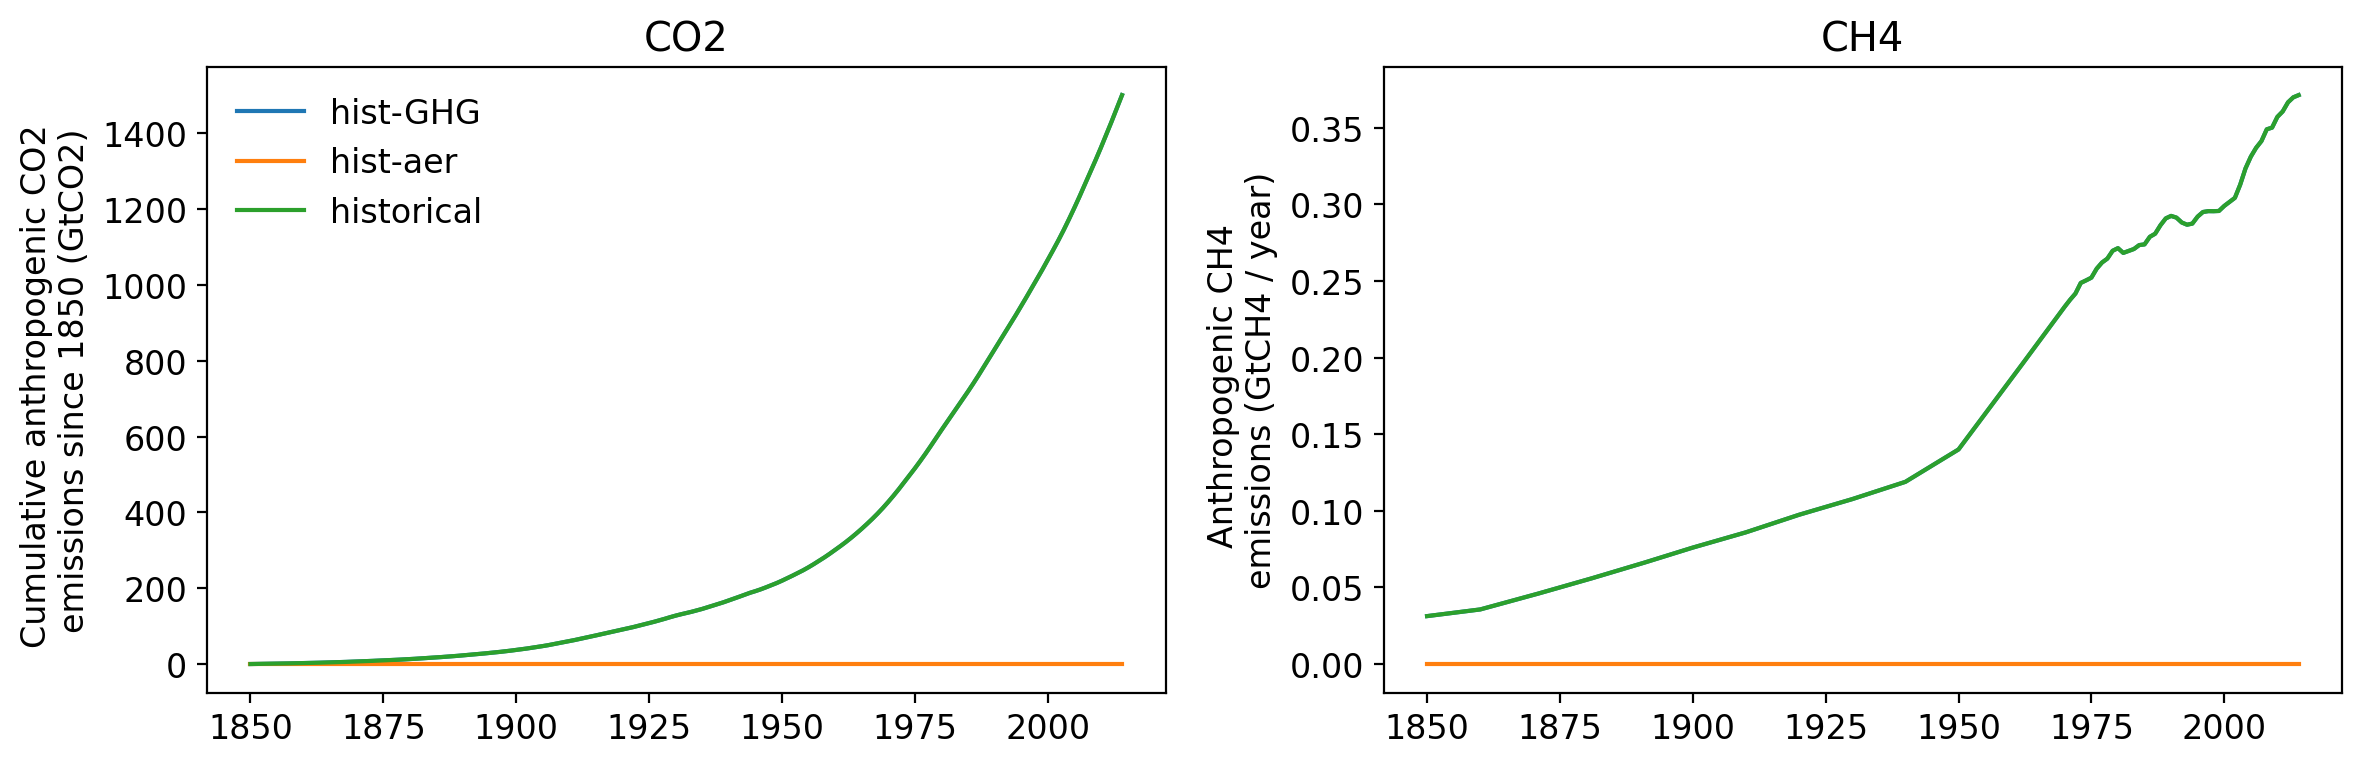

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
SECONDS_IN_YEAR = 60*60*24*365 #s
for input in inputs:

    label=input.split('_')[-1][:-3]
    X = xr.open_dataset(input)
    x = range(1850, 2015)

    weights = np.cos(np.deg2rad(X.latitude))

    axes[0].plot(x, X['CO2'].data, label=label)
    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[1].plot(x, X['CH4'].data, label=label)
    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")

axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()

ValueError: ignored

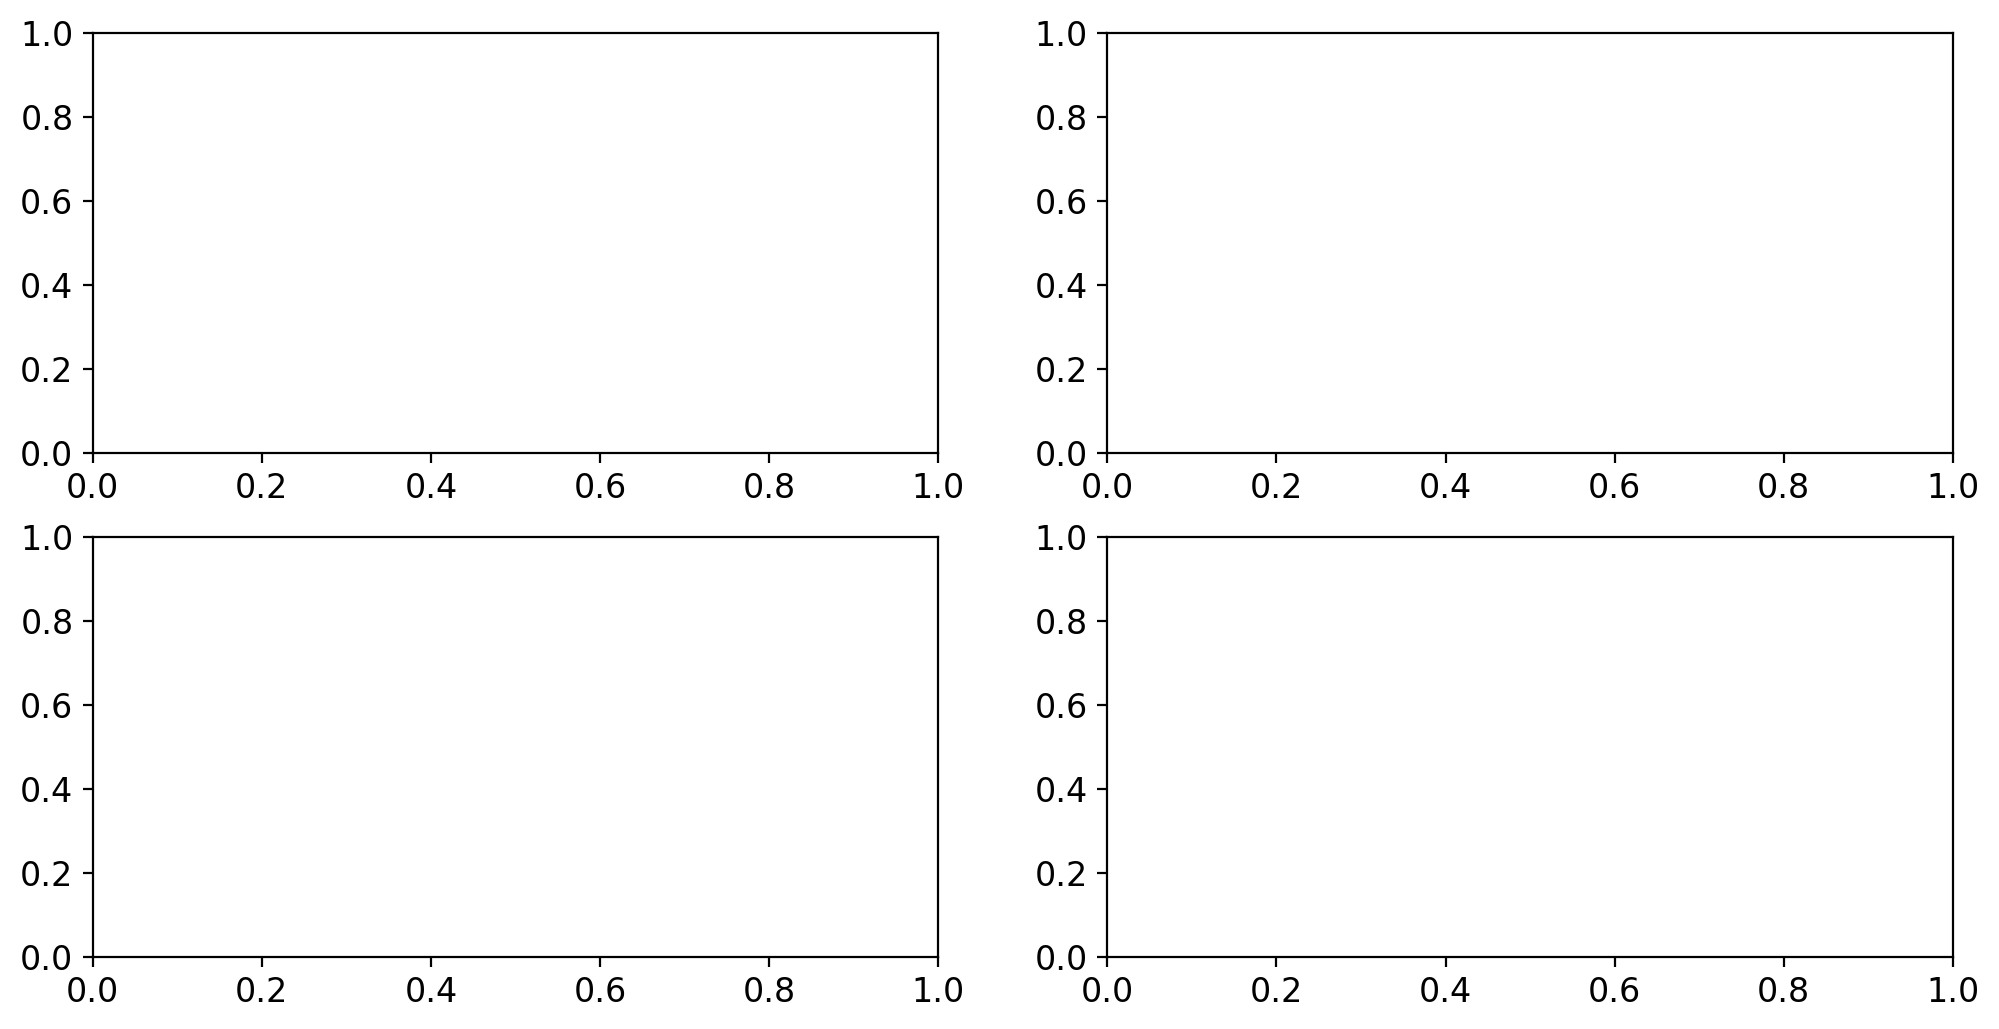

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
SECONDS_IN_YEAR = 60*60*24*365 #s


label= 'historical'
X = xr.open_dataset(inputs)
x = range(1850, 2015)

weights = np.cos(np.deg2rad(X.latitude))

axes[0,0].plot(x, X['CO2'].data, label=label,color = 'red')
axes[0,0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")


axes[0,1].plot(x, X['CH4'].data, label='CH4')
axes[0,1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")


axes[1,0].plot(x, convert(global_sum(X['SO2']*AREA_of_EARTH*1000*100)), label=label)
axes[1,0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")


axes[1,1].plot(x, convert(global_sum(X['BC']*AREA_of_EARTH*1000*100)), label=label)
axes[1,1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")



axes[0,0].set_title('CO2')
axes[0,1].set_title('CH4')
axes[1,0].set_title('SO2')
axes[1,1].set_title('BC')
axes[0,0].legend()
plt.tight_layout()


#Note that hist-GHG has the exact same CO2 & CH4 changes as historical

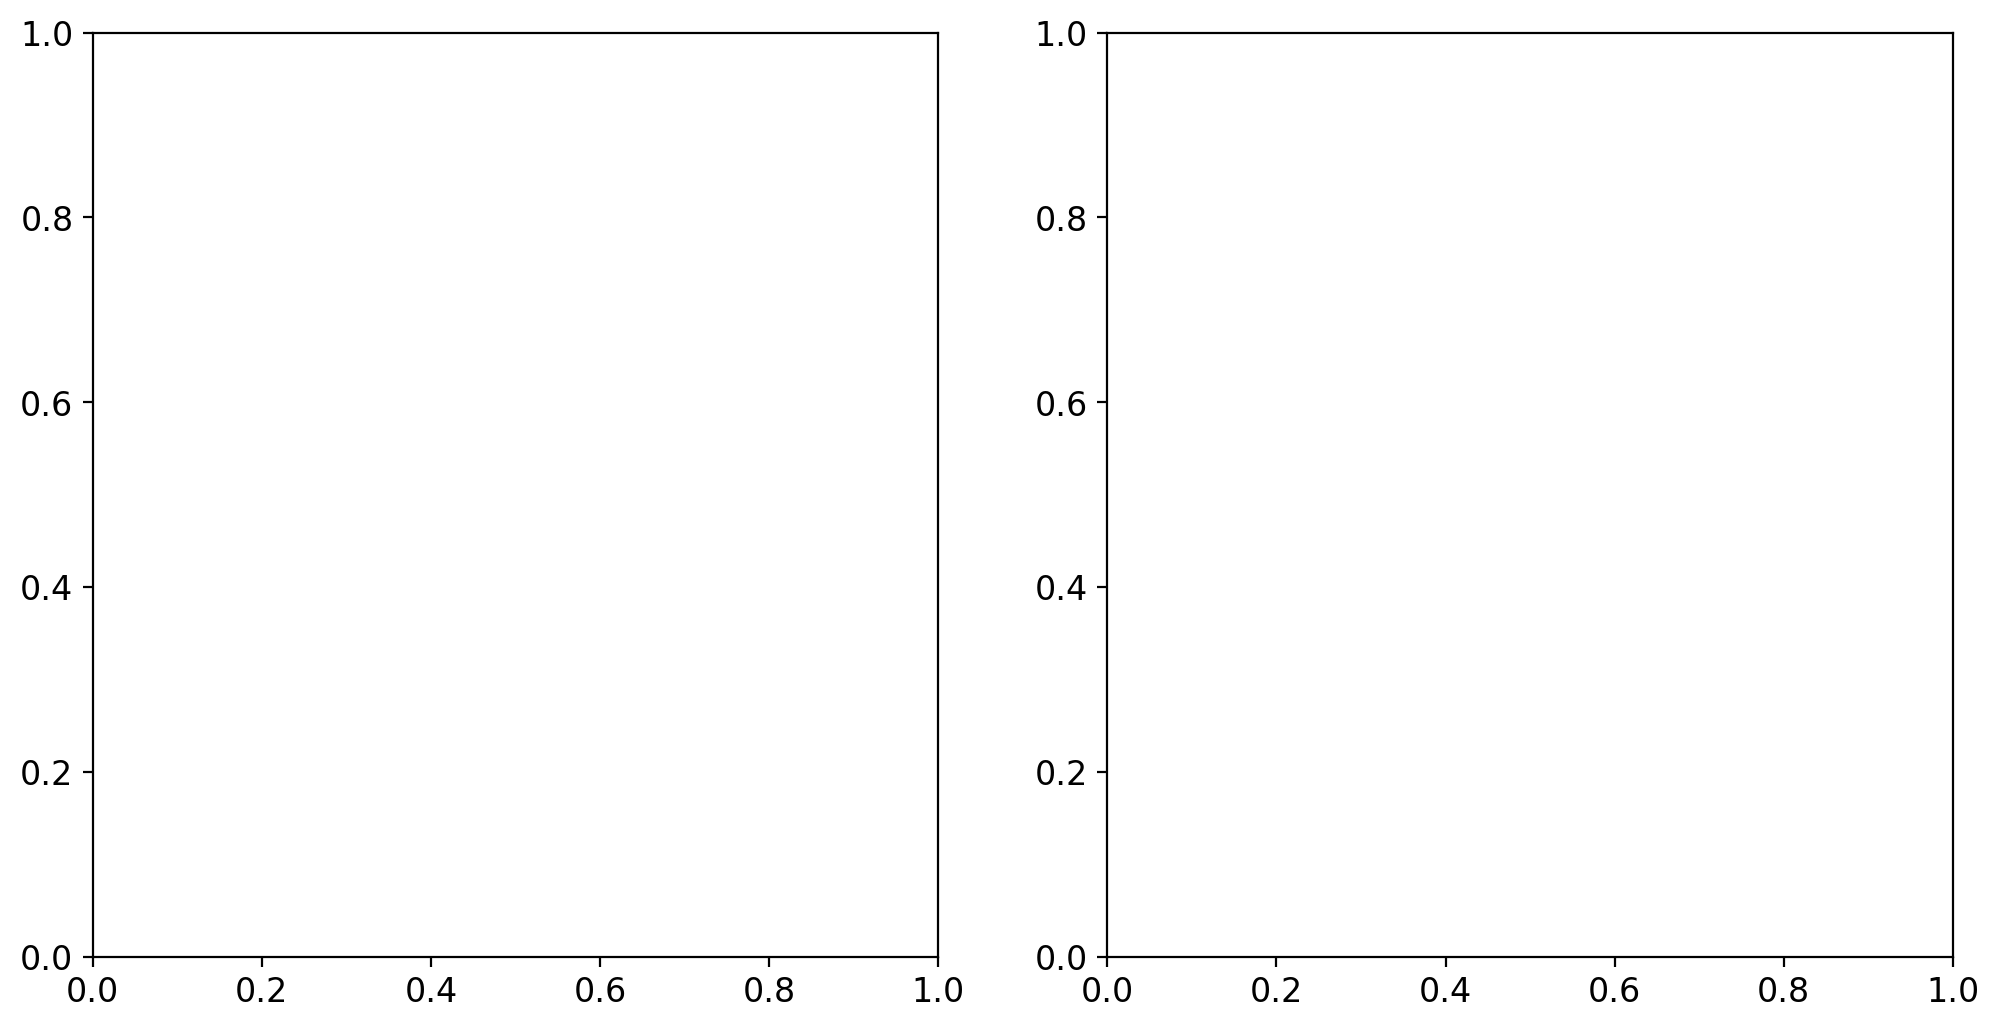

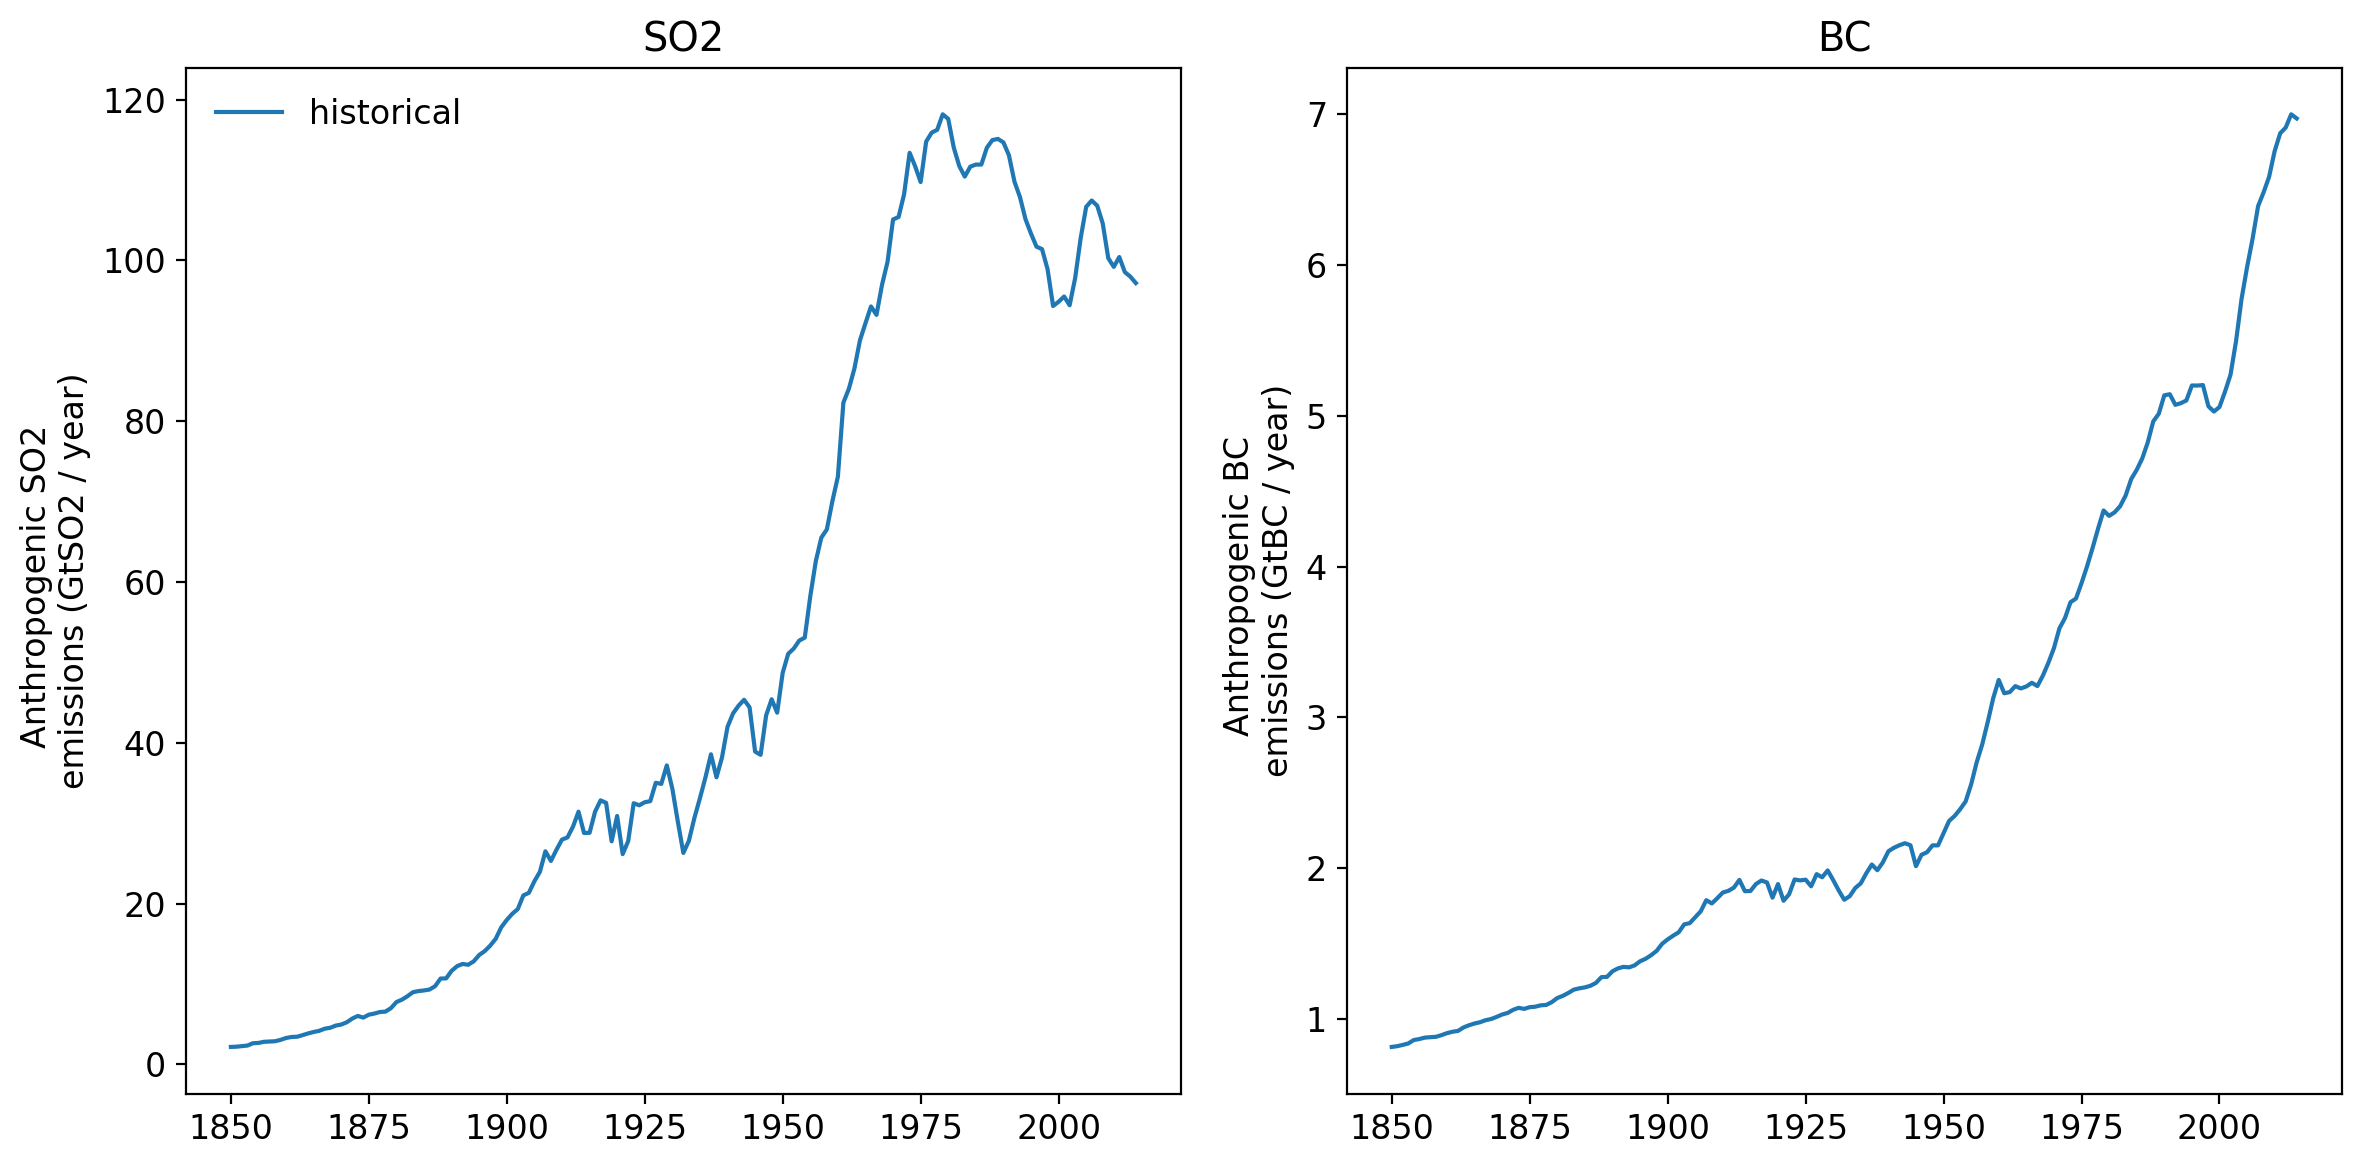

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
SECONDS_IN_YEAR = 60*60*24*365 #s


label= 'historical'
X = xr.open_dataset(input)
x = range(1850, 2015)

weights = np.cos(np.deg2rad(X.latitude))




axes[0].plot(x, convert(global_sum(X['SO2']*AREA_of_EARTH*1000*100)), label=label)
axes[0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")


axes[1].plot(x, convert(global_sum(X['BC']*AREA_of_EARTH*1000*100)), label=label)
axes[1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")




axes[0].set_title('SO2')
axes[1].set_title('BC')
axes[0].legend()
plt.tight_layout()

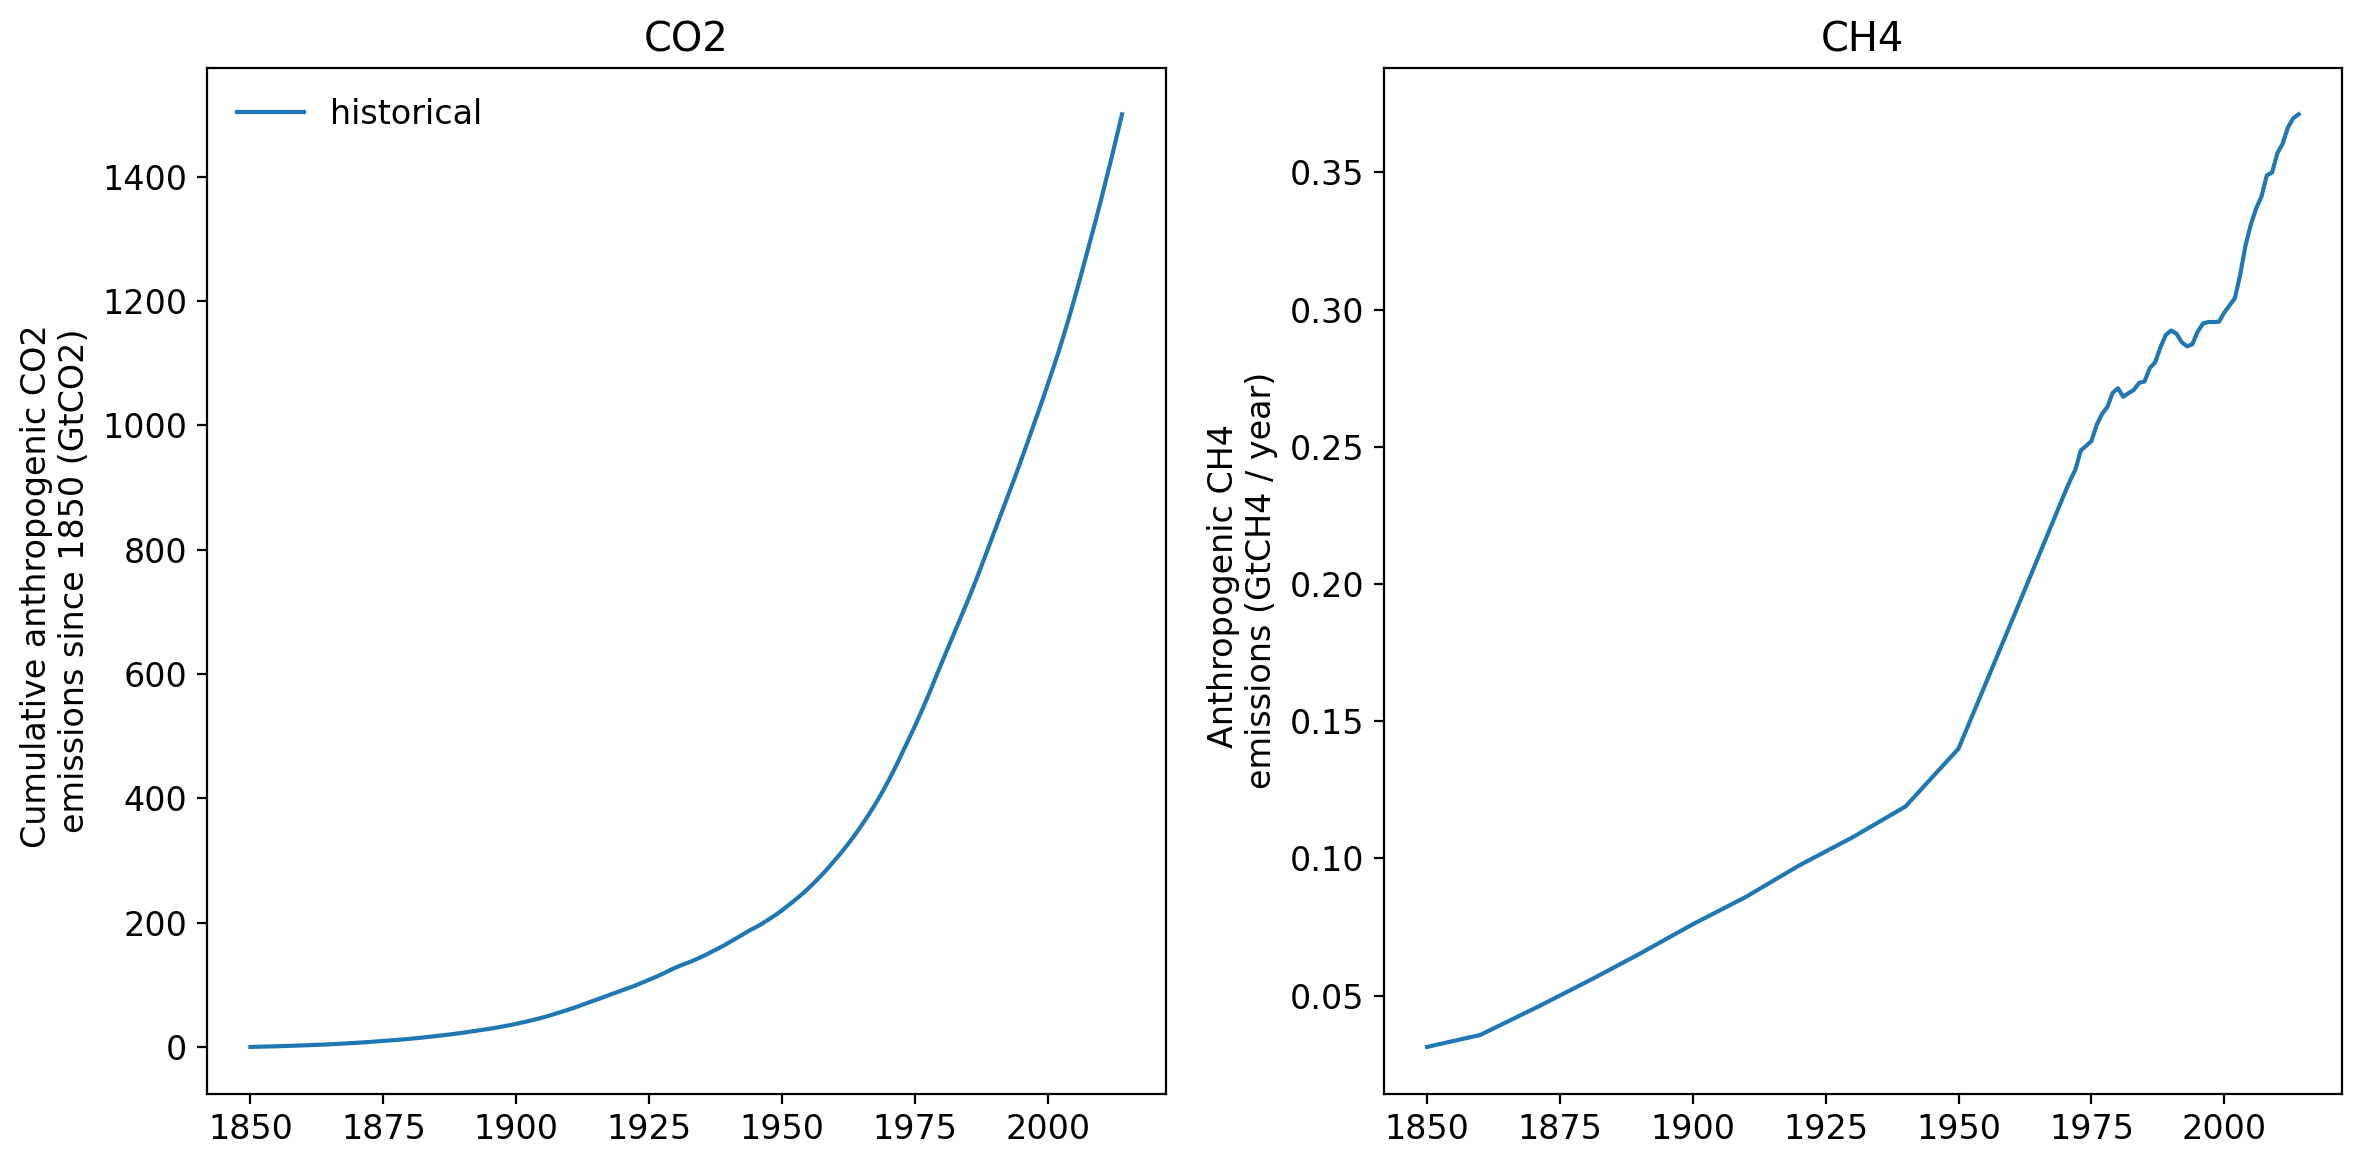

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#fig, axes = plt.subplots(1, 2, figsize=(12, 6))
SECONDS_IN_YEAR = 60*60*24*365 #s


label= 'historical'
X = xr.open_dataset(input)
x = range(1850, 2015)

weights = np.cos(np.deg2rad(X.latitude))

axes[0].plot(x, X['CO2'].data, label=label)
axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")


axes[1].plot(x, X['CH4'].data, label='CH4')
axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()

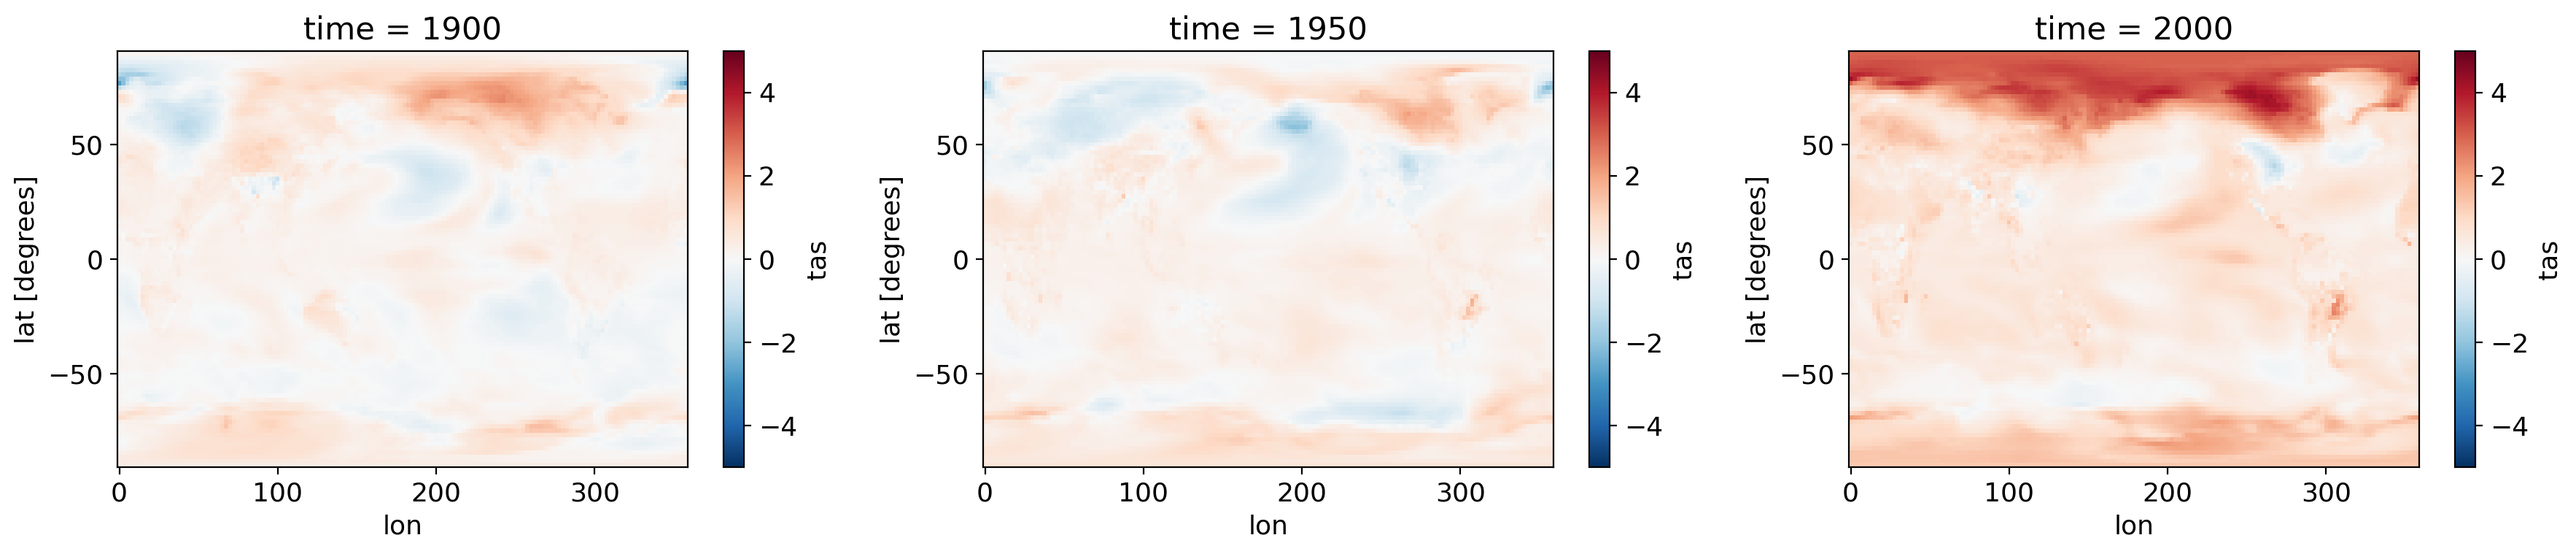

In [ ]:
y = xr.open_dataset(os.path.join(train_path , "outputs_historical.nc")).mean(dim="member")[['tas']].drop(['quantile'])


fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 1900, 1950, 2000
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()

In [26]:
input1 = glob(os.path.join(train_path, "inputs_s*.nc"))
input1.sort()
#inputs += glob(os.path.join(test_path, "inputs_s*.nc"))

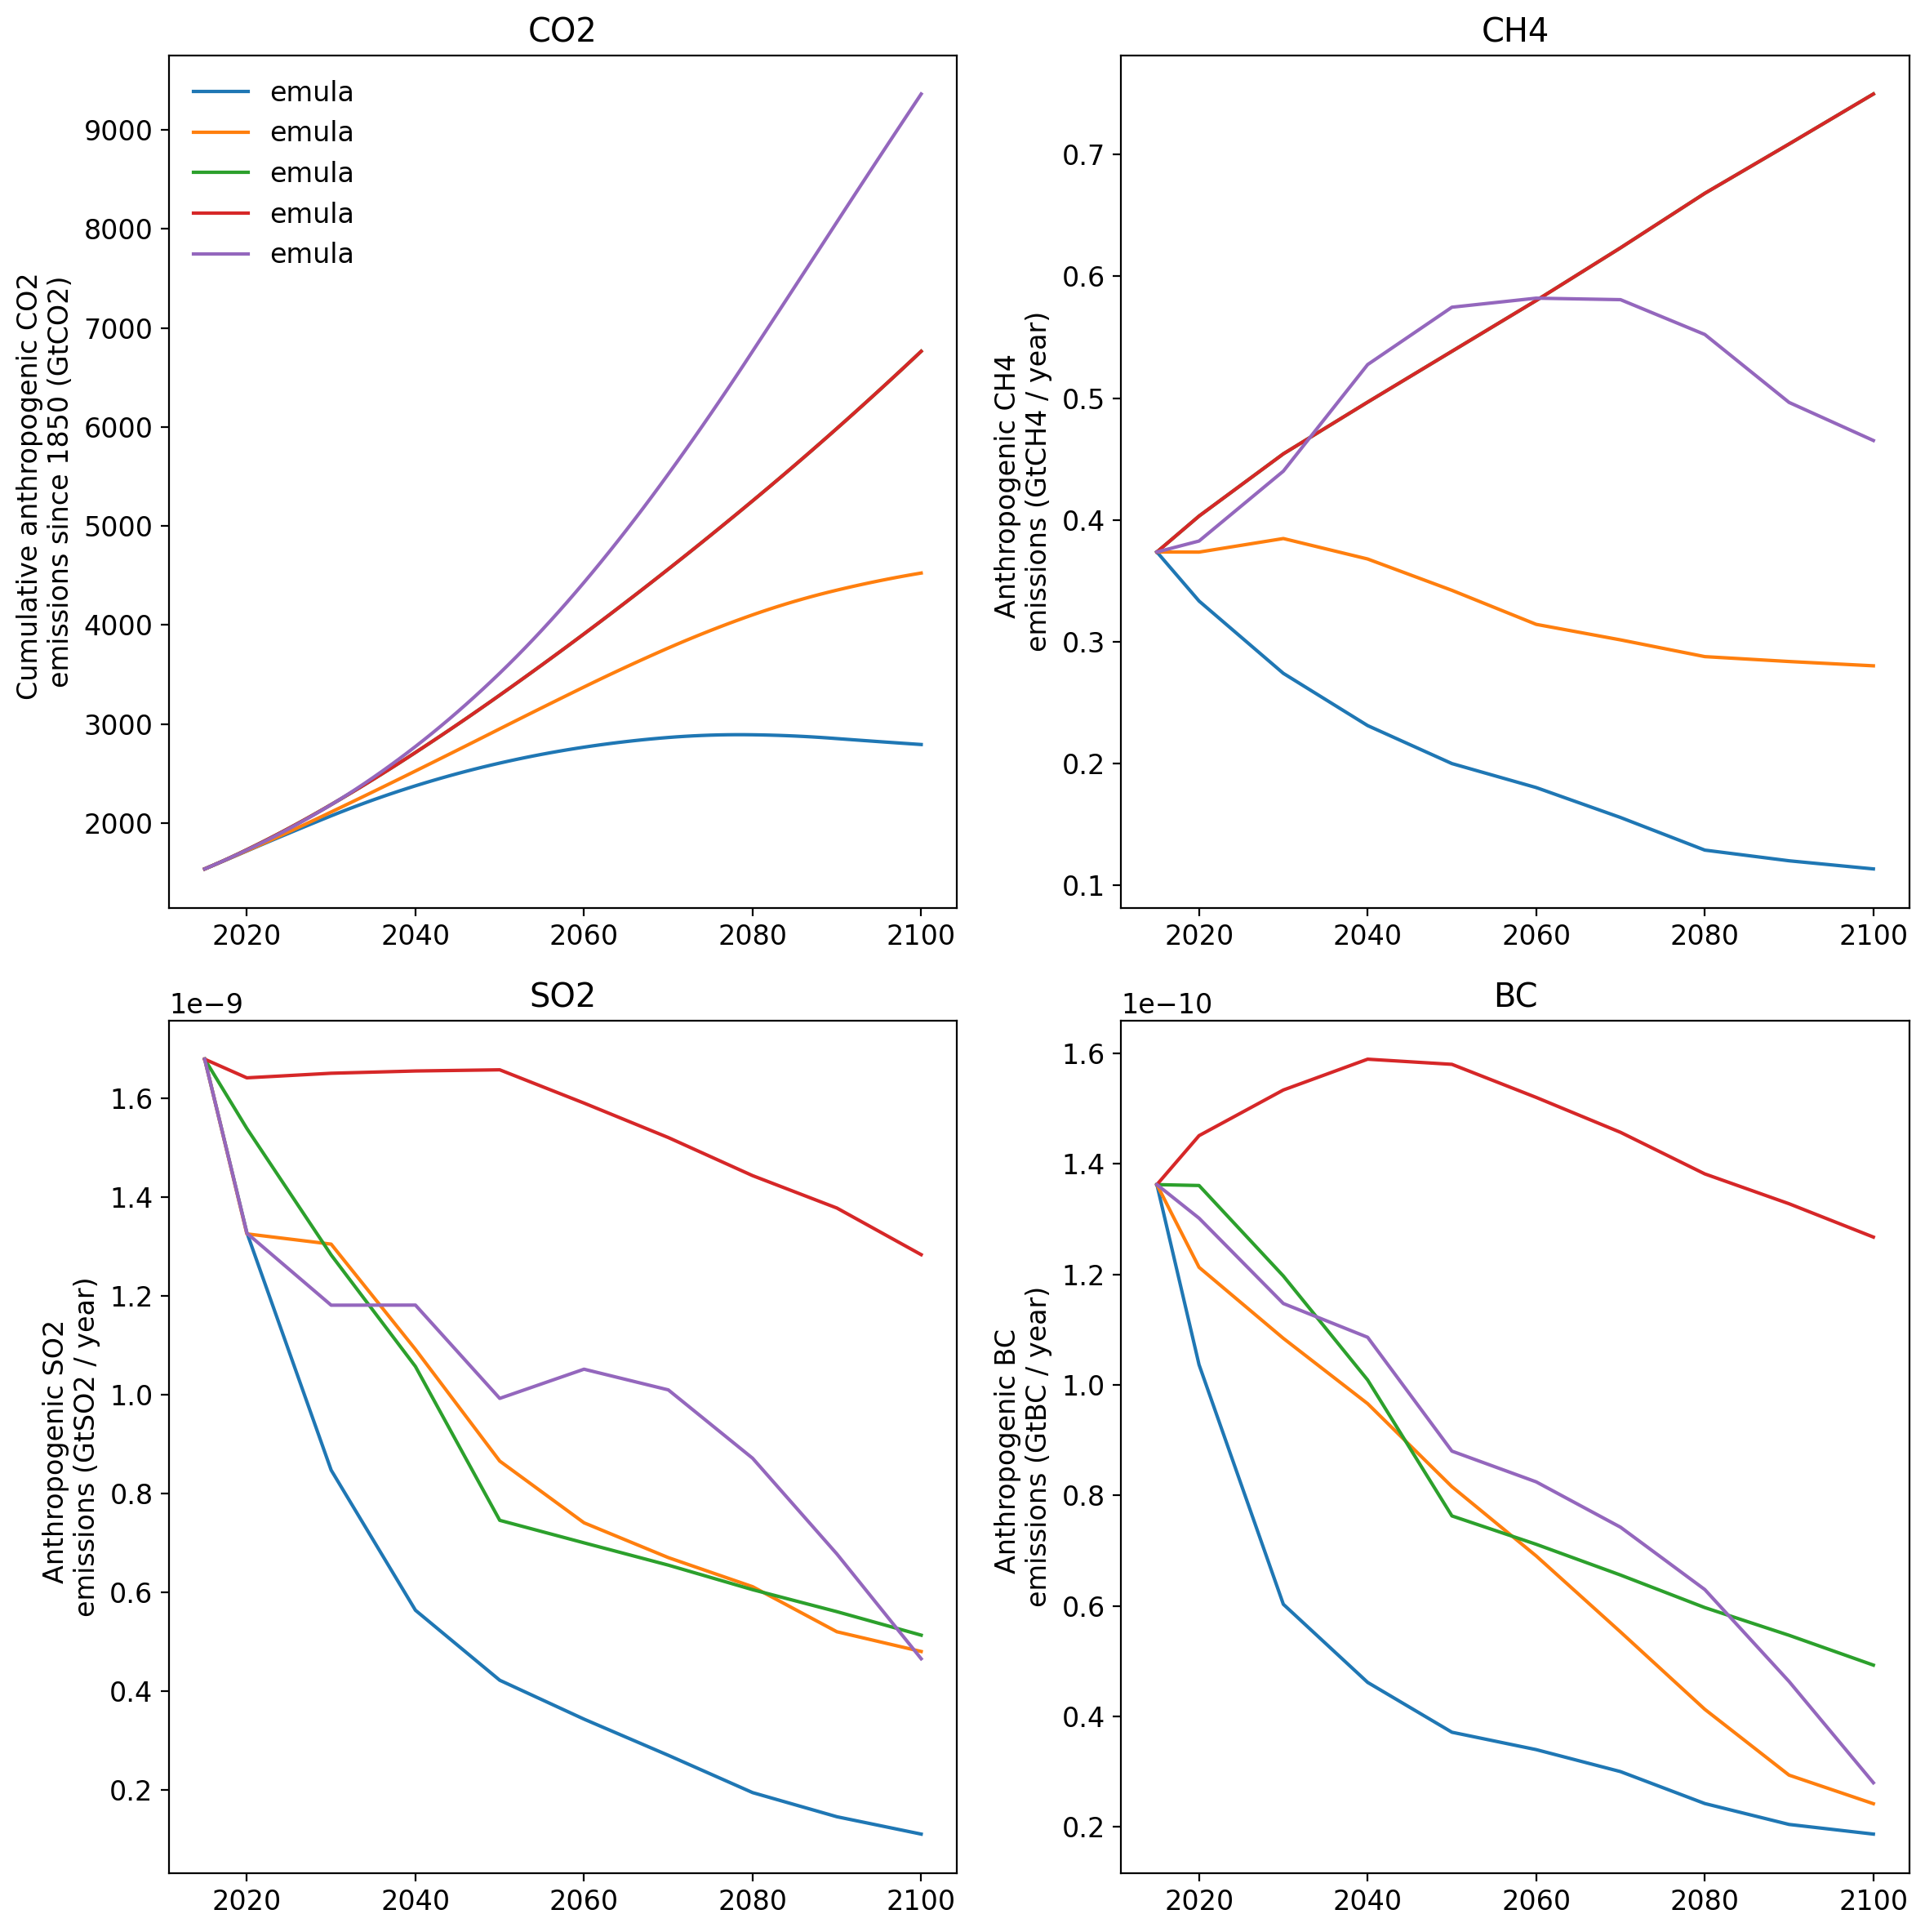

In [25]:
from glob import glob

inputs = input1
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))

    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

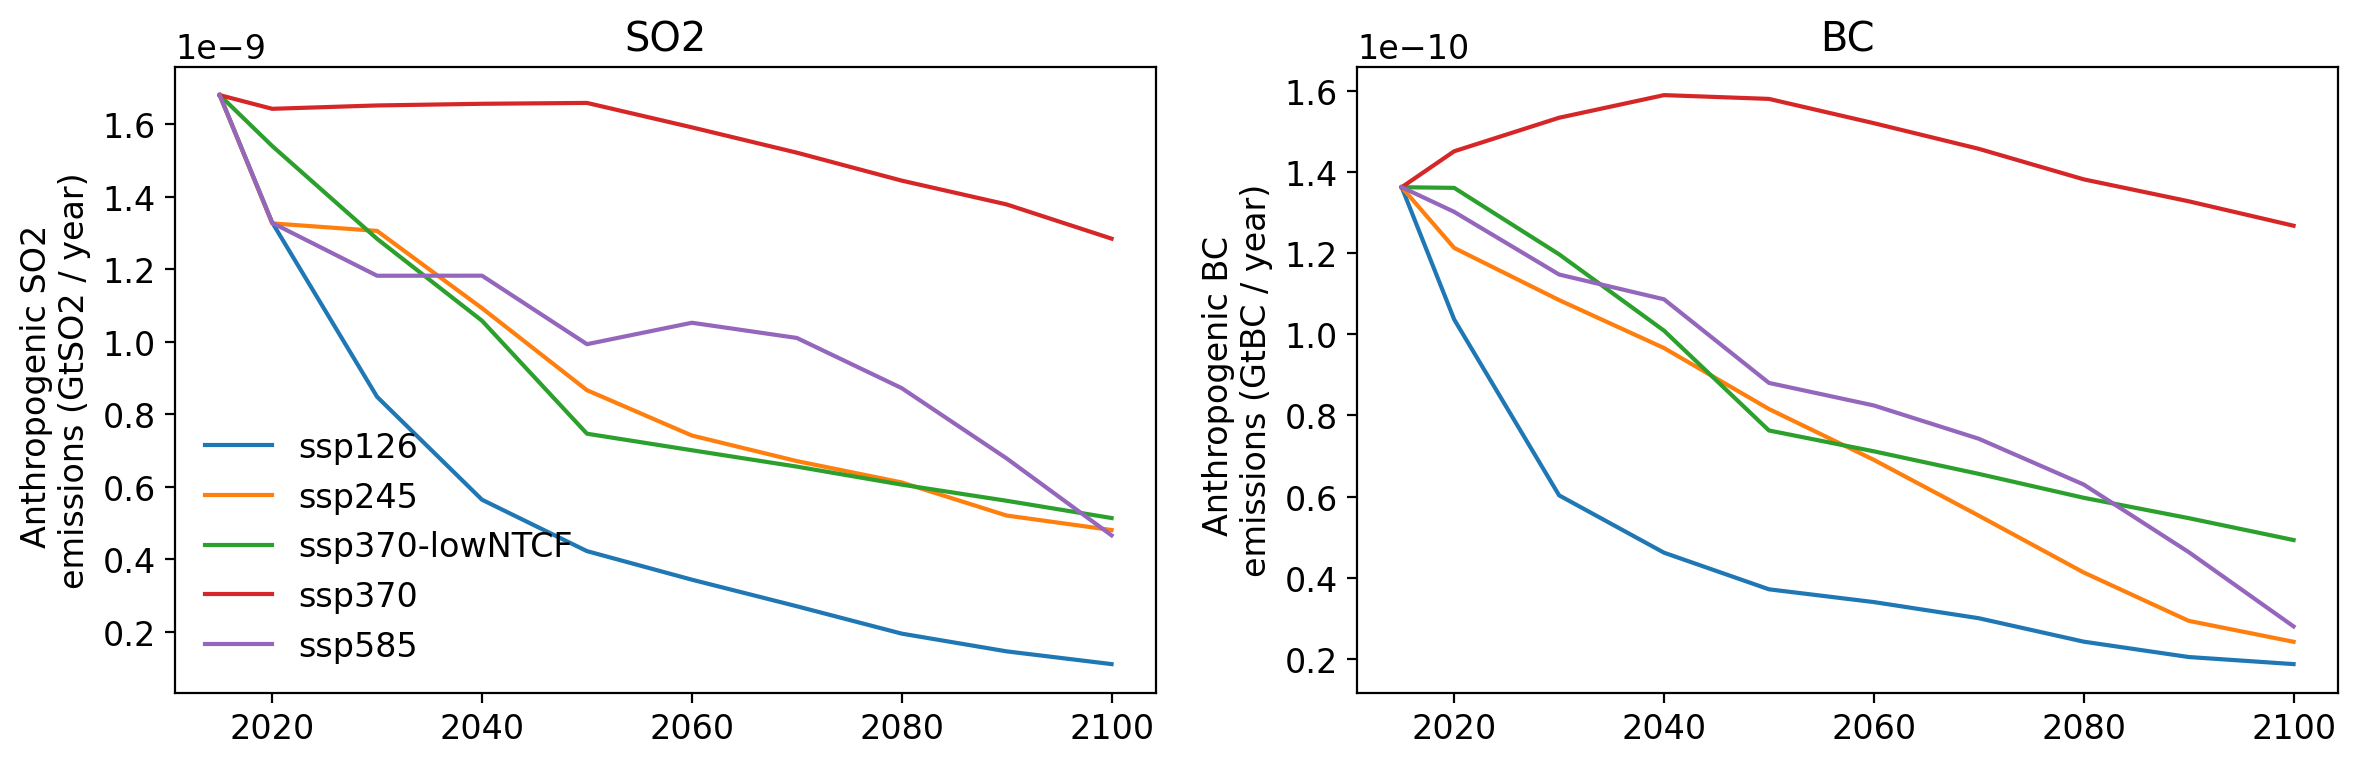

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
SECONDS_IN_YEAR = 60*60*24*365 #s
for input in input1:

    label=input.split('_')[-1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))

    axes[0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*(1e-9), label=label)
    axes[0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*(1e-9), label=label)
    axes[1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0].set_title('SO2')
axes[1].set_title('BC')
axes[0].legend()
plt.tight_layout()

In [ ]:
inputs

['/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp126.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp245.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp370-lowNTCF.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp370.nc',
 '/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/inputs_ssp585.nc']

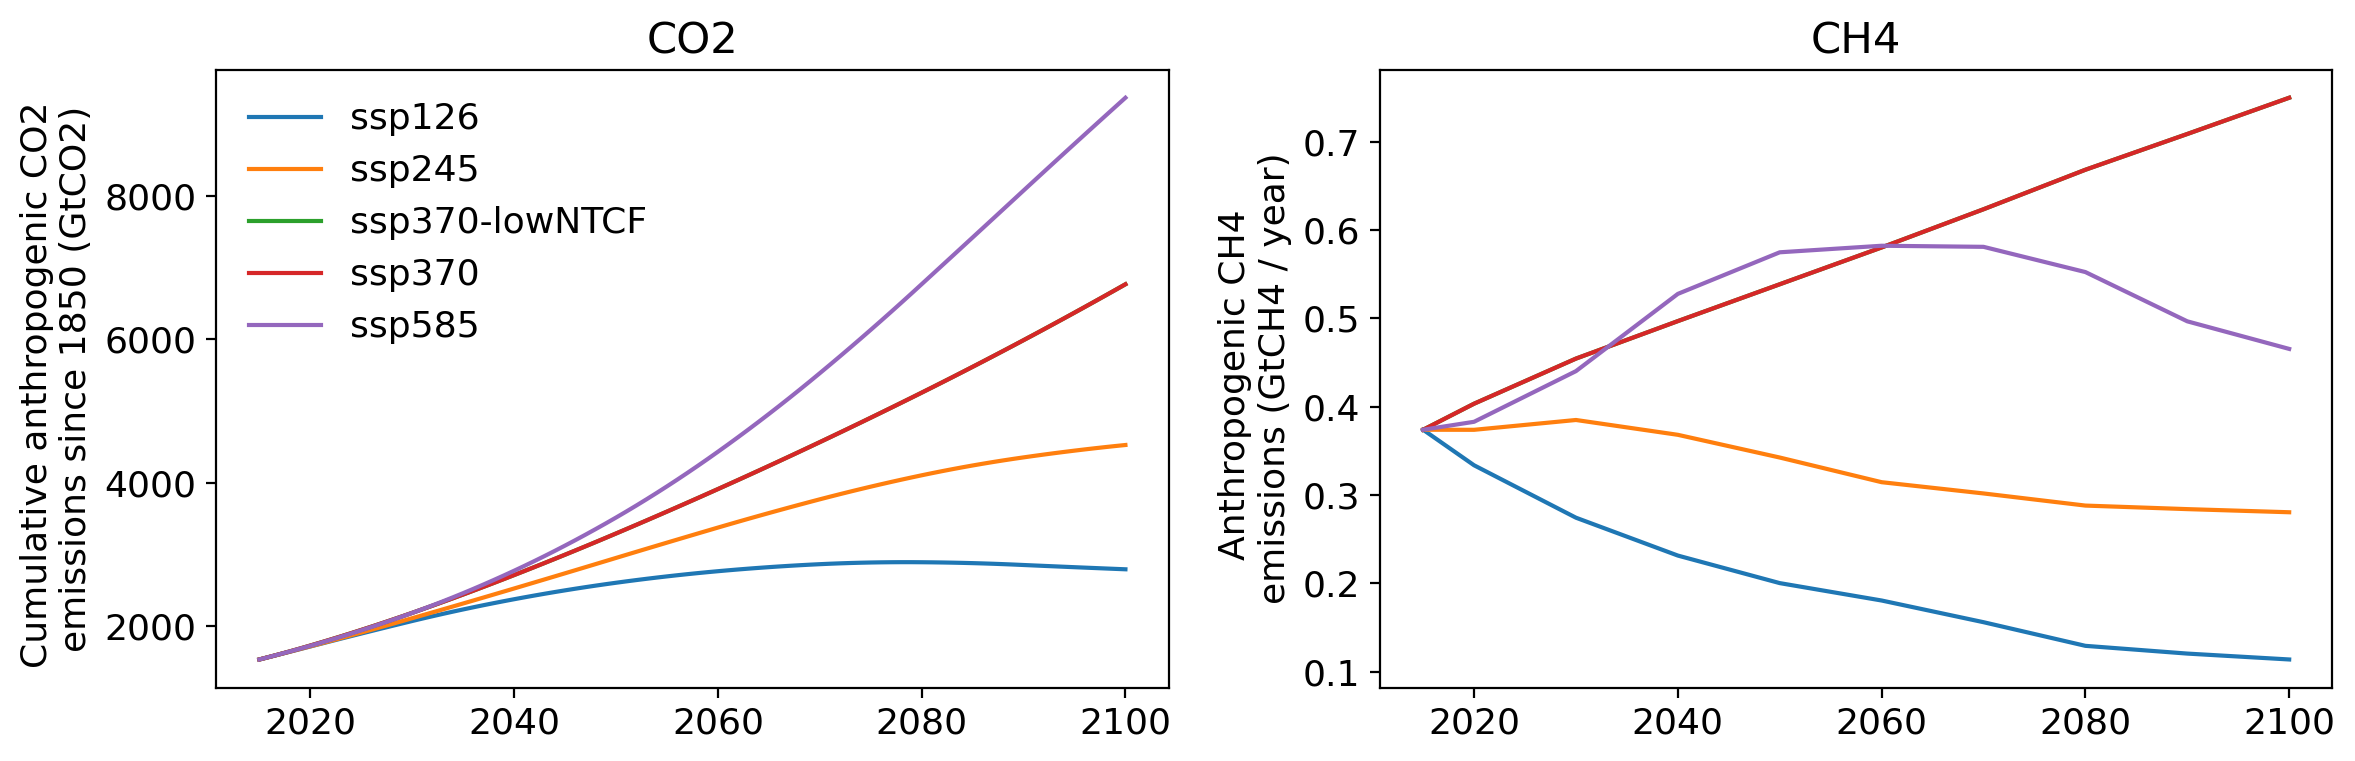

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
SECONDS_IN_YEAR = 60*60*24*365 #s
for input in inputs:

    label=input.split('_')[-1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))

    axes[0].plot(x, X['CO2'].data, label=label)
    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[1].plot(x, X['CH4'].data, label=label)
    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")

axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()

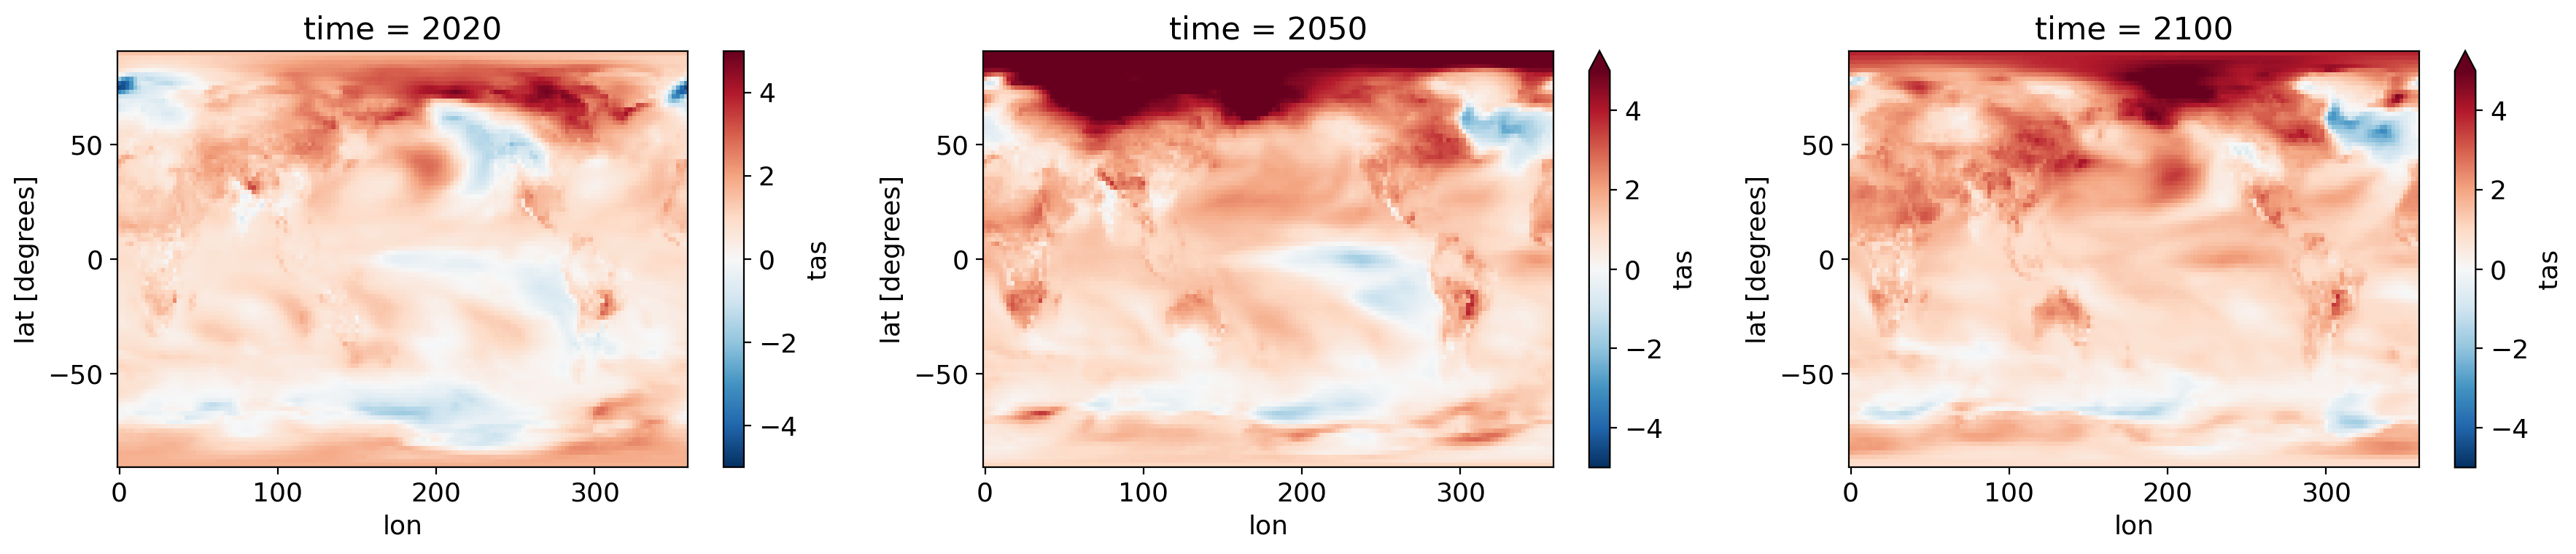

In [ ]:
y = xr.open_dataset(os.path.join(train_path,'outputs_ssp126.nc')).mean(dim="member")[['tas']].drop(['quantile'])

fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()

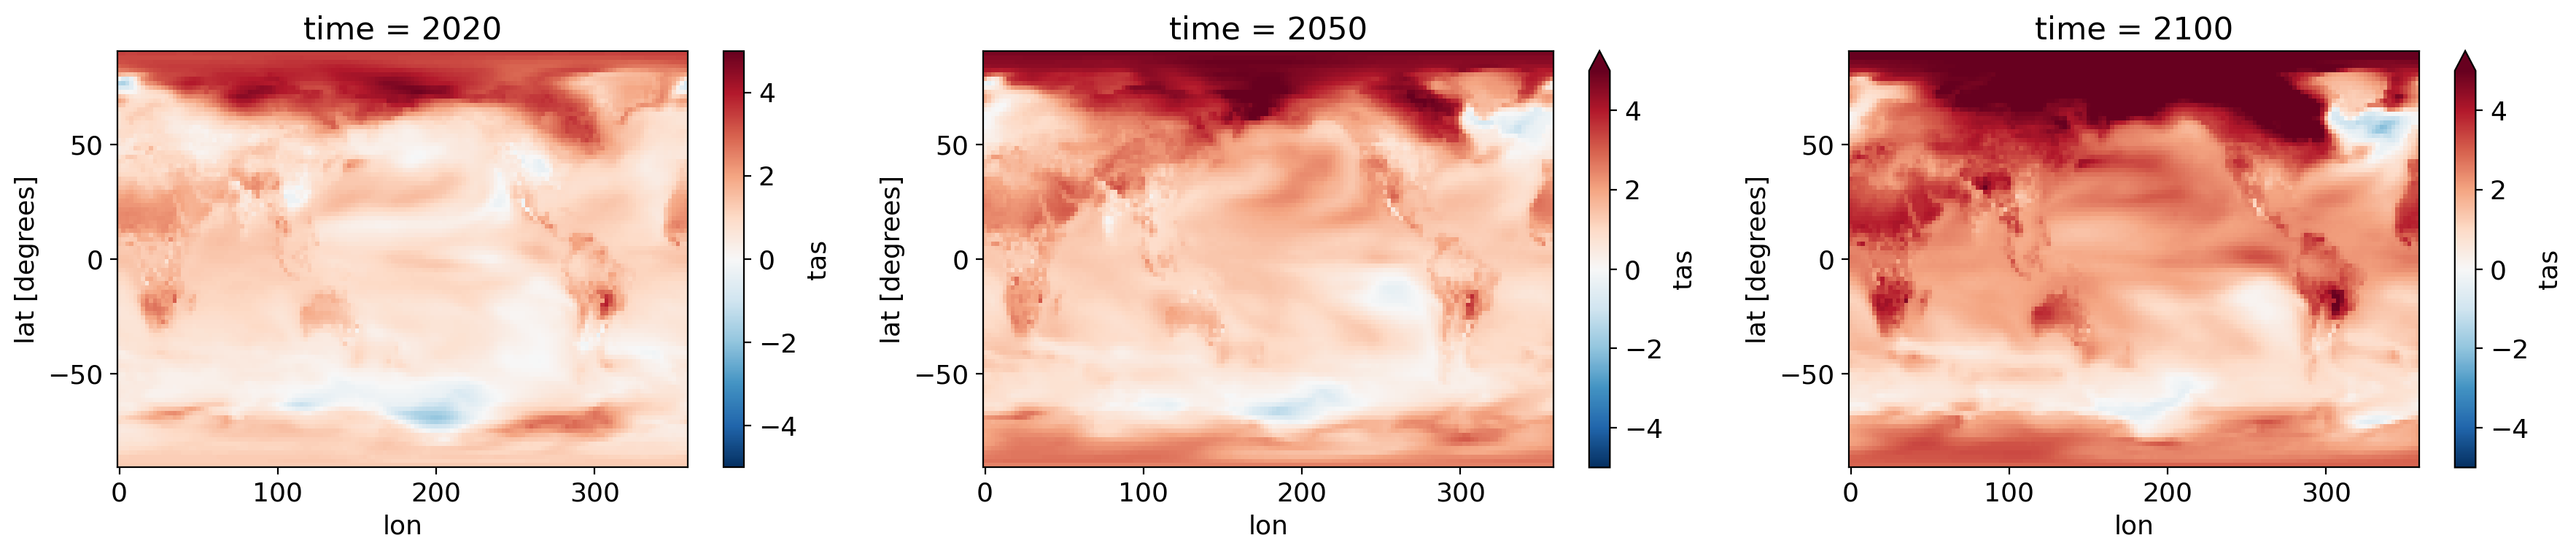

In [ ]:
y = xr.open_dataset(os.path.join(train_path,'outputs_ssp245.nc')).mean(dim="member")[['tas']].drop(['quantile'])

fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()

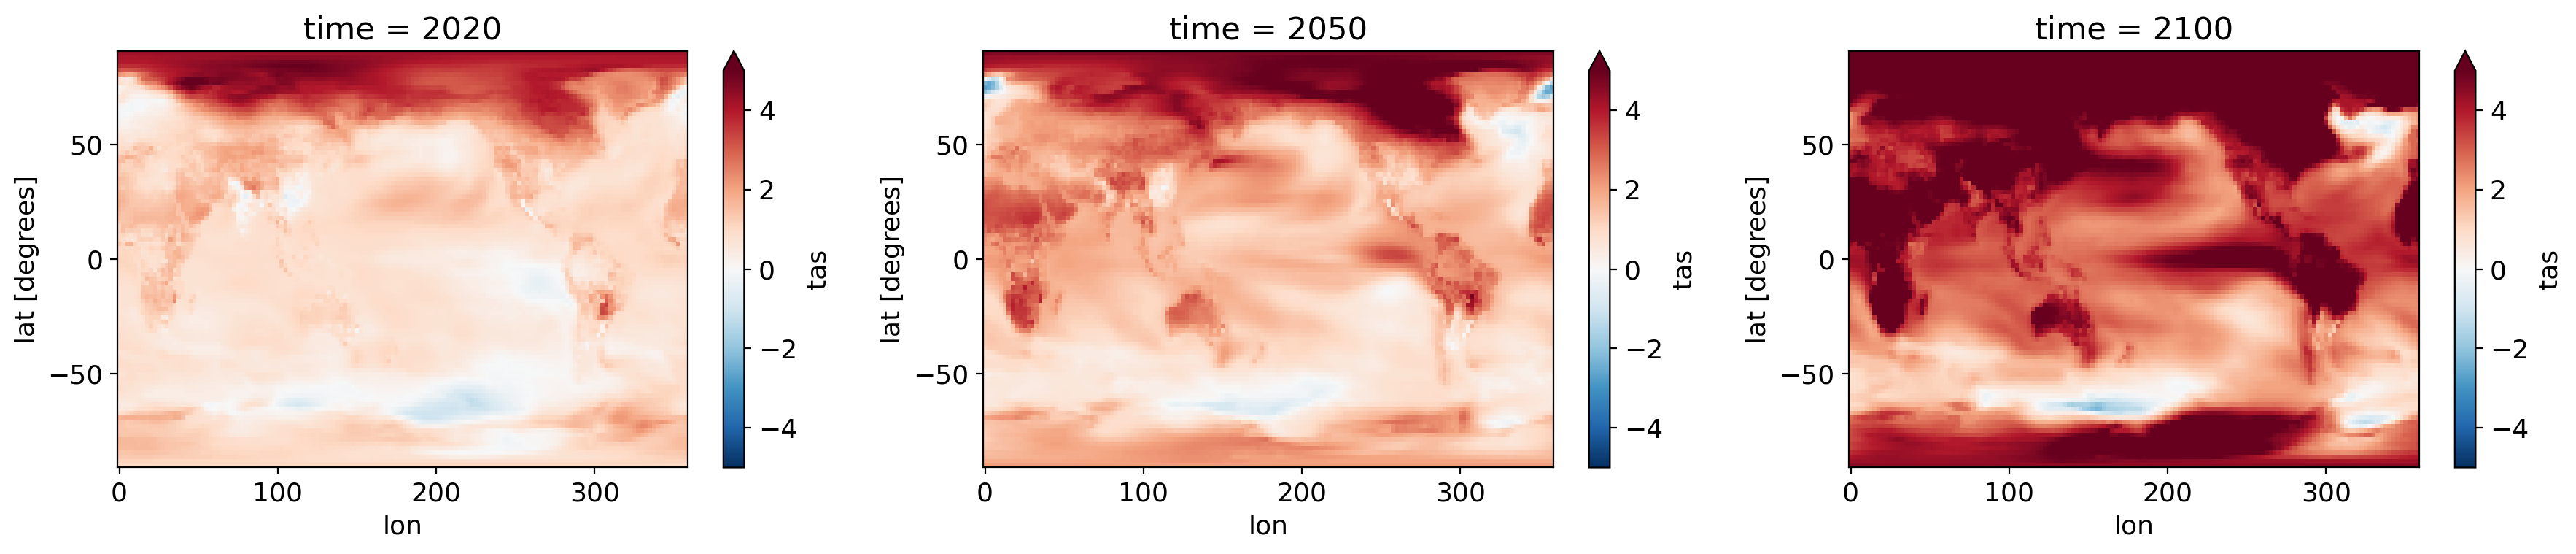

In [ ]:
y = xr.open_dataset(os.path.join(train_path,'outputs_ssp370.nc')).mean(dim="member")[['tas']].drop(['quantile'])

fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()

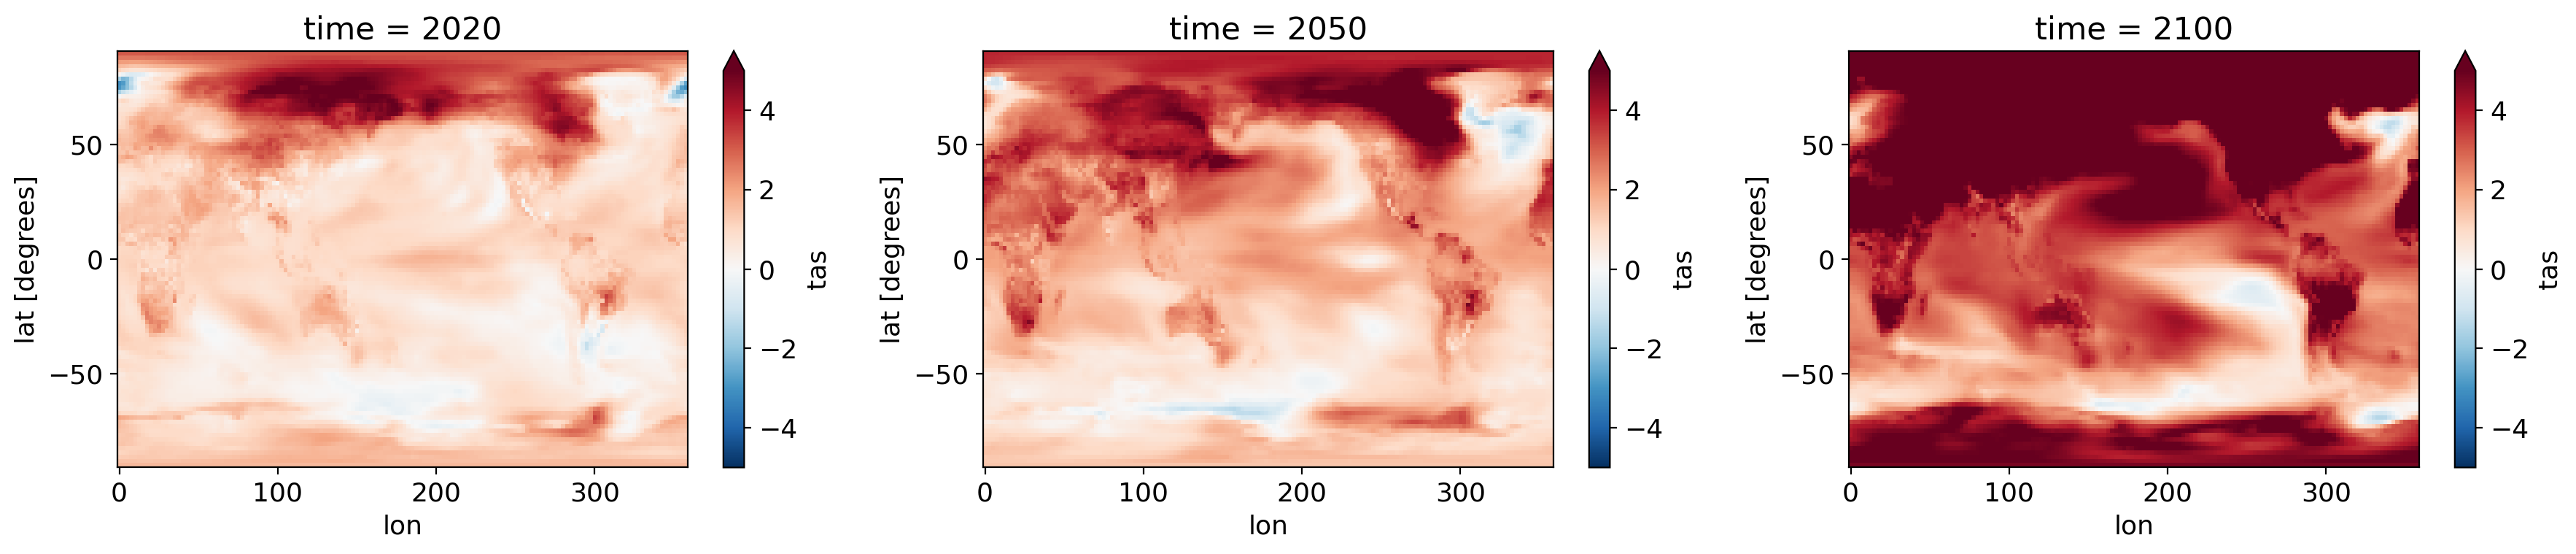

In [ ]:
y = xr.open_dataset(os.path.join(train_path,'outputs_ssp585.nc')).mean(dim="member")[['tas']].drop(['quantile'])

fig,axes = plt.subplots(figsize=(18,4),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y.sel(time=yr0).tas.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr1).tas.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y.sel(time=yr2).tas.plot(ax=axes[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

plt.tight_layout()